# RL for Autonomous Vehicle Tasks: Safety and Traffic Optimization

## Agents

In [14]:
# TODO: define agents here

## Scenarios

In [15]:
import gymnasium
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline
from stable_baselines3 import DQN, PPO, A2C, SAC
from stable_baselines3.common.monitor import Monitor
import logging
import json
import os
import numpy as np
import tensorboard

### Car following

In [16]:
def speed_matching_reward(v_ego, v_lead):
    return 1.0 - abs(v_ego - v_lead) / max(v_lead, 1.0)  # Normalize to [0, 1].

def safe_distance_penalty(d_rel, v_rel):
    desired_distance = 2.0  # Optimal distance in meters.
    safe_margin = 1.0       # Allowable range around desired distance.
    if d_rel < desired_distance - safe_margin:  # Too close, penalize heavily
        return -1.0
    elif d_rel > desired_distance + safe_margin:  # Too far, minor penalty
        return -0.2
    else:  # Reward for being at a safe following distance
        return 0.5

def optimal_speed_range_reward(v_ego, v_lead, v_min=10, v_max=15):
    if (v_ego < v_min or v_ego > v_max) and v_lead > v_ego: 
        return -0.5
    else:
        return 0.2

def reward_function(env, ego_vehicle, lead_vehicle):
    d_rel = lead_vehicle.position[0] - ego_vehicle.position[0]
    v_rel = lead_vehicle.velocity[0] - ego_vehicle.velocity[0]
    v_ego = ego_vehicle.velocity[0]
    v_lead = lead_vehicle.velocity[0]

    # Parameters
    desired_distance = 10.0  # Optimal distance in meters.
    safe_distance_margin = 5.0  # Allowable deviation from desired distance.
    optimal_speed = 30.0  # Optimal cruising speed in m/s.

    # Safe distance reward
    if d_rel < desired_distance - safe_distance_margin:
        safe_distance_reward = -1.0  # Penalty for being too close.
    elif d_rel > desired_distance + safe_distance_margin:
        safe_distance_reward = -0.5  # Penalty for being too far.
    else:
        safe_distance_reward = 1.0  # Reward for maintaining safe distance.

    # Speed matching reward
    speed_match_reward = 1.0 - abs(v_ego - v_lead) / max(v_lead, 1.0)

    acceleration_reward = 0.0
    if lead_vehicle is None:  # If no car ahead
        if v_ego < optimal_speed:
            acceleration_reward = 0.3  # Reward for accelerating to optimal speed
        elif v_ego > optimal_speed + 5.0:
            acceleration_reward = -0.5  # Penalty for going too fast
        else:
            acceleration_reward = 0
    else:
        acceleration_reward = 0

    # Collision penalty
    if ego_vehicle.crashed:
        collision_penalty = -10.0
    else:
        collision_penalty = 0.0

    # Reward for reaching target distance safely
    target_distance = env.road.network.get_lane(ego_vehicle.lane_index).length
    if ego_vehicle.position[0] > target_distance:
        target_distance_reward = 10.0
    else:
        target_distance_reward = 0.0


    reward_on_road = 0.00
    penalty_off_road = -6.0

    offroad_penalty = 0.0

    if ego_vehicle.position[0] < env.road.x_min or ego_vehicle.position[0] > env.road.x_max or \
       ego_vehicle.position[1] < env.road.y_min or ego_vehicle.position[1] > env.road.y_max:
        
        env.done = True  
        offroad_penalty += penalty_off_road
    
    else:
        offroad_penalty += reward_on_road

    # Combine rewards
    total_reward = (
        safe_distance_reward +
        speed_match_reward +
        acceleration_reward +
        collision_penalty +
        target_distance_reward + 
        offroad_penalty
    )

    return total_reward


# Discrete action space environment
car_following_discrete = gymnasium.make('highway-v0', render_mode="rgb_array")
car_following_discrete.unwrapped.configure({
    "vehicles_count": 2,
    "controlled_vehicles": 1,
    "lanes_count": 1,
    "action": {
        "type": "DiscreteMetaAction"  # Uses a discrete action space supported by your algorithm.
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,
        "features": ["x", "y", "vx", "vy"],
        "absolute": False,
        "normalize": True
    },
    "screen_width": 600,             
    "screen_height": 600,
    "duration": 100,                  
    "offscreen_rendering": True, 
    "show_trajectories": True
})
car_following_discrete.reset()
car_following_discrete.reward_function = lambda obs, action: reward_function(
    car_following_discrete, car_following_discrete.vehicle, car_following_discrete.road.vehicles[1]
)

# Continuous action space environment
car_following_continuous = gymnasium.make('highway-v0', render_mode="rgb_array")
car_following_continuous.unwrapped.configure({
    "vehicles_count": 2,
    "controlled_vehicles": 1,
    "lanes_count": 1,
    "action": {
        "type": "ContinuousAction"  # Define continuous actions for smooth control.
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,
        "features": ["x", "y", "vx", "vy"],
        "absolute": False,
        "normalize": True
    },
    "screen_width": 600,             
    "screen_height": 600,
    "duration": 100,                  
    "offscreen_rendering": True, 
    "show_trajectories": True
})
car_following_continuous.reset()
car_following_continuous.reward_function = lambda obs, action: reward_function(
    car_following_continuous, car_following_continuous.vehicle, car_following_continuous.road.vehicles[1]
)

car_following_discrete_default = gymnasium.make('highway-v0', render_mode="rgb_array")
car_following_discrete_default.unwrapped.configure({
    "vehicles_count": 2,
    "controlled_vehicles": 1,
    "lanes_count": 1,
    "action": {
        "type": "DiscreteMetaAction"  # Uses a discrete action space supported by your algorithm.
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,
        "features": ["x", "y", "vx", "vy"],
        "absolute": False,
        "normalize": True
    },
    "screen_width": 600,             
    "screen_height": 600,
    "duration": 100,                  
    "offscreen_rendering": True, 
    "show_trajectories": True
})
car_following_discrete_default.reset()

(array([[ 1.        ,  0.        ,  0.3125    ,  0.        ],
        [ 0.16929455,  0.        , -0.01449605,  0.        ],
        [ 0.31592324,  0.        , -0.04852666,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

### Overtaking

In [17]:
def overtaking_reward_function(env, ego_vehicle, road_vehicles):
    d_rel = road_vehicles[0].position[0] - ego_vehicle.position[0]
    v_rel = road_vehicles[0].velocity[0] - ego_vehicle.velocity[0]
    ego_lane = ego_vehicle.lane_index
    safe_distance = 2.0

    # Safe distance reward
    safe_distance_reward = safe_distance_penalty(d_rel, v_rel)
    
    # Speed matching reward
    speed_match_reward = speed_matching_reward(ego_vehicle.velocity[0], road_vehicles[0].velocity[0])

    # Overtaking rewards
    overtaking_reward = 0
    overtaking_priority_reward = 0
    if ego_vehicle.position[0] > road_vehicles[0].position[0] and ego_vehicle.lane_index != 1:
        overtaking_reward = 5  # Successfully overtakes
    if d_rel < safe_distance and v_rel < 0 and ego_vehicle.lane_index != 1:
        overtaking_priority_reward = 3  # Incentivize overtaking when necessary

    # Lane-specific rewards
    right_lane_return_reward = 0
    if ego_vehicle.lane_index == 1 and ego_vehicle.position[0] > road_vehicles[0].position[0]:
        right_lane_return_reward = 3  # Reward returning to the right lane

    correct_lane_reward = 2 if ego_vehicle.lane_index == 1 else 0
    unnecessary_lane_change_penalty = -1 if abs(ego_vehicle.lane_index - 1) > 1 else 0

    # Free lane speed reward
    max_speed = 30  # Assuming max speed of 30 m/s
    free_lane_speed_reward = 0
    if d_rel > safe_distance and ego_vehicle.lane_index == 1:
        free_lane_speed_reward = min(ego_vehicle.velocity[0] / max_speed, 1.0)

    # Collision and off-road penaltiesA%#W
    if ego_vehicle.crashed:
        return -10.0
    if ego_vehicle.position[0] < env.road.x_min or ego_vehicle.position[0] > env.road.x_max or \
       ego_vehicle.position[1] < env.road.y_min or ego_vehicle.position[1] > env.road.y_max:
        env.done = True  
        return -6.0

    # Combine all rewards
    total_reward = (safe_distance_reward +
                    speed_match_reward +
                    overtaking_reward +
                    overtaking_priority_reward +
                    right_lane_return_reward +
                    correct_lane_reward +
                    unnecessary_lane_change_penalty +
                    free_lane_speed_reward)

    return total_reward

overtaking_discrete = gymnasium.make('highway-v0', render_mode="rgb_array")
overtaking_discrete.unwrapped.configure({
    "vehicles_count": 10,  # Increased vehicle count to make the traffic denser.
    "controlled_vehicles": 1,  # One controlled vehicle (ego vehicle).
    "lanes_count": 2,  # More lanes to test the agent's ability to overtake in traffic.
    "road_type": "straight",  # Use straight road to make traffic management simpler (but still complex).
    "vehicles_density": 0.5,  # Higher density for more vehicles.
    "action": {
        "type": "DiscreteMetaAction"  # Discrete action space suitable for DQN and A2C
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,  # Including traffic vehicles.
        "features": ["x", "y", "vx", "vy"],  # Key kinematic features.
        "absolute": False,
        "normalize": True  # Normalize observations.
    },
    "screen_width": 800,  # Larger screen for a wider view of the environment.
    "screen_height": 800,  # Larger height for better vehicle representation.
    "duration": 200,  # Increase the duration to simulate longer driving periods.
    "offscreen_rendering": True,
    "show_trajectories": True,  # Keep track of trajectories to see pathing.
    "traffic_density": 0.5,  # Increased traffic density for better generalization.
    "highway_length": 4000  # Make the highway longer to simulate more complex navigation.
})
overtaking_discrete.reset()
overtaking_discrete.reward_function = lambda obs, action: overtaking_reward_function(
    overtaking_discrete, overtaking_discrete.vehicle, overtaking_discrete.road.vehicles[1:]
)

overtaking_discrete_default = gymnasium.make('highway-v0', render_mode="rgb_array")
overtaking_discrete_default.unwrapped.configure({
    "vehicles_count": 10,  # Increased vehicle count to make the traffic denser.
    "controlled_vehicles": 1,  # One controlled vehicle (ego vehicle).
    "lanes_count": 2,  # More lanes to test the agent's ability to overtake in traffic.
    "road_type": "straight",  # Use straight road to make traffic management simpler (but still complex).
    "vehicles_density": 0.5,  # Higher density for more vehicles.
    "action": {
        "type": "DiscreteMetaAction"  # Discrete action space suitable for DQN and A2C
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,  # Including traffic vehicles.
        "features": ["x", "y", "vx", "vy"],  # Key kinematic features.
        "absolute": False,
        "normalize": True  # Normalize observations.
    },
    "screen_width": 800,  # Larger screen for a wider view of the environment.
    "screen_height": 800,  # Larger height for better vehicle representation.
    "duration": 200,  # Increase the duration to simulate longer driving periods.
    "offscreen_rendering": True,
    "show_trajectories": True,  # Keep track of trajectories to see pathing.
    "traffic_density": 0.5,  # Increased traffic density for better generalization.
    "highway_length": 4000  # Make the highway longer to simulate more complex navigation.
})
overtaking_discrete_default.reset()

(array([[ 1.        ,  0.5       ,  0.3125    ,  0.        ],
        [ 0.26173285,  0.        , -0.04366517,  0.        ],
        [ 0.52758205, -0.5       , -0.03363441,  0.        ],
        [ 0.80321056, -0.5       , -0.01799832,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

### Highway cruising

In [18]:
# Environment for Discrete Actions (DQN, A2C)
highway_cruising_discrete = gymnasium.make('highway-v0', render_mode="rgb_array")
highway_cruising_discrete.unwrapped.configure({
    "vehicles_count": 50,  # Increased vehicle count to make the traffic denser.
    "controlled_vehicles": 1,  # One controlled vehicle (ego vehicle).
    "lanes_count": 3,  # More lanes to test the agent's ability to overtake in traffic.
    "road_type": "straight",  # Use straight road to make traffic management simpler (but still complex).
    "vehicles_density": 1.0,  # Higher density for more vehicles.
    "action": {
        "type": "DiscreteMetaAction"  # Discrete action space suitable for DQN and A2C
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,  # Including traffic vehicles.
        "features": ["x", "y", "vx", "vy"],  # Key kinematic features.
        "absolute": False,
        "normalize": True  # Normalize observations.
    },
    "screen_width": 800,  # Larger screen for a wider view of the environment.
    "screen_height": 800,  # Larger height for better vehicle representation.
    "duration": 300,  # Increase the duration to simulate longer driving periods.
    "offscreen_rendering": True,
    "show_trajectories": True,  # Keep track of trajectories to see pathing.
    "traffic_density": 1.5,  # Increased traffic density for better generalization.
    "highway_length": 4000  # Make the highway longer to simulate more complex navigation.
})

# Reset environment
highway_cruising_discrete.reset()

# Assign the reward function
highway_cruising_discrete.reward_function = lambda obs, action: overtaking_reward_function(
    highway_cruising_discrete, highway_cruising_discrete.vehicle, highway_cruising_discrete.road.vehicles
)


# Continuous action space - Configuration for PPO and SAC
highway_cruising_continuous = gymnasium.make('highway-v0', render_mode="rgb_array")
highway_cruising_continuous.unwrapped.configure({
    "vehicles_count": 50,  # Increased vehicle count to make the traffic denser.
    "controlled_vehicles": 1,  # One controlled vehicle (ego vehicle).
    "lanes_count": 3,  # More lanes to test the agent's ability to overtake in traffic.
    "road_type": "straight",  # Use straight road to make traffic management simpler (but still complex).
    "vehicles_density": 1.0,  # Higher density for more vehicles.
    "action": {
        "type": "ContinuousAction"  # Continuous action space for PPO and SAC
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,  # Including traffic vehicles.
        "features": ["x", "y", "vx", "vy"],  # Key kinematic features.
        "absolute": False,
        "normalize": True  # Normalize observations.
    },
    "screen_width": 800,  # Larger screen for a wider view of the environment.
    "screen_height": 800,  # Larger height for better vehicle representation.
    "duration": 300,  # Increase the duration to simulate longer driving periods.
    "offscreen_rendering": True,
    "show_trajectories": True,  # Keep track of trajectories to see pathing.
    "traffic_density": 1.5,  # Increased traffic density for better generalization.
    "highway_length": 4000  # Make the highway longer to simulate more complex navigation.
})
# Reset environment
highway_cruising_continuous.reset()
# Assign the reward function
highway_cruising_continuous.reward_function = lambda obs, action: overtaking_reward_function(
    highway_cruising_continuous, highway_cruising_continuous.vehicle, highway_cruising_continuous.road.vehicles
)

highway_cruising_discrete_default = gymnasium.make('highway-v0', render_mode="rgb_array")
highway_cruising_discrete_default.unwrapped.configure({
    "vehicles_count": 50,  # Increased vehicle count to make the traffic denser.
    "controlled_vehicles": 1,  # One controlled vehicle (ego vehicle).
    "lanes_count": 3,  # More lanes to test the agent's ability to overtake in traffic.
    "road_type": "straight",  # Use straight road to make traffic management simpler (but still complex).
    "vehicles_density": 1.0,  # Higher density for more vehicles.
    "action": {
        "type": "DiscreteMetaAction"  # Discrete action space suitable for DQN and A2C
    },
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20,  # Including traffic vehicles.
        "features": ["x", "y", "vx", "vy"],  # Key kinematic features.
        "absolute": False,
        "normalize": True  # Normalize observations.
    },
    "screen_width": 800,  # Larger screen for a wider view of the environment.
    "screen_height": 800,  # Larger height for better vehicle representation.
    "duration": 300,  # Increase the duration to simulate longer driving periods.
    "offscreen_rendering": True,
    "show_trajectories": True,  # Keep track of trajectories to see pathing.
    "traffic_density": 1.5,  # Increased traffic density for better generalization.
    "highway_length": 4000  # Make the highway longer to simulate more complex navigation.
})
highway_cruising_discrete_default.reset()

(array([[ 1.        ,  0.        ,  0.3125    ,  0.        ],
        [ 0.11140124,  0.        , -0.03304518,  0.        ],
        [ 0.23029228,  0.33333334, -0.03936743,  0.        ],
        [ 0.3420619 ,  0.6666667 , -0.03968649,  0.        ],
        [ 0.44797164,  0.6666667 , -0.03769681,  0.        ],
        [ 0.55621785,  0.        , -0.04981107,  0.        ],
        [ 0.68128026,  0.        , -0.01258286,  0.        ],
        [ 0.81029075,  0.33333334, -0.02203241,  0.        ],
        [ 0.9191973 ,  0.33333334, -0.04135961,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

### Roundabout

In [19]:
def roundabout_reward_function(env, ego_vehicle, road_vehicles):
    # Rewards and penalties
    merging_reward = 0
    exiting_reward = 0
    collision_penalty = 0
    yielding_reward = 0
    smoothness_penalty = 0
    wrong_way_penalty = 0
    optimal_speed_bonus = 0
    intermediate_reward = 0  # New: reward for intermediate progress in actions

    # Determine ego-vehicle states
    is_in_roundabout = ego_vehicle.lane_index == env.roundabout_lane_index
    is_exiting_roundabout = ego_vehicle.is_exiting_roundabout()  # Exiting logic needed
    is_yielding = ego_vehicle.is_yielding()
    speed = ego_vehicle.velocity[0]

    # Reward for merging successfully into the roundabout
    if is_in_roundabout and not ego_vehicle.just_entered_roundabout():
        merging_reward = 5  # Encourage entering roundabout correctly

    # Reward for exiting roundabout successfully
    if is_exiting_roundabout:
        exiting_reward = 10  # High reward for completing the roundabout navigation

    # Penalty for collision
    if ego_vehicle.crashed:
        collision_penalty = -10.0  # Strongly discourage collisions

    # Yielding appropriately (optional reward)
    if is_yielding:
        yielding_reward = 2  # Small reward for good yielding behavior

    # Penalize stalling or stopping unnecessarily
    if speed < 0.1 and not is_yielding:
        smoothness_penalty = -2  # Penalize unnecessary stopping

    # Penalize wrong-way navigation
    if not ego_vehicle.is_in_correct_lane():
        wrong_way_penalty = -5  # Penalize entering/exiting via wrong lanes

    # Bonus for maintaining a safe speed inside roundabout
    if is_in_roundabout:
        if env.config["reward_speed_range"][0] <= speed <= env.config["reward_speed_range"][1]:
            optimal_speed_bonus = 1.0  # Encourage navigating at appropriate speeds

    # Intermediate reward for progress (for continuous actions, we can reward gradual approach)
    if is_in_roundabout and not is_exiting_roundabout:
        intermediate_reward = 1.0  # Reward for making progress in the roundabout

    # Off-road penalty (new penalty for off-lane behavior)
    reward_on_road = 0.00
    penalty_off_road = -6.0

    offroad_penalty = 0.0

    if ego_vehicle.position[0] < env.road.x_min or ego_vehicle.position[0] > env.road.x_max or \
       ego_vehicle.position[1] < env.road.y_min or ego_vehicle.position[1] > env.road.y_max:
        
        env.done = True  
        offroad_penalty += penalty_off_road
    
    else:
        offroad_penalty += reward_on_road
        

    # Combine all reward components
    total_reward = (
        merging_reward +
        exiting_reward +
        yielding_reward +
        optimal_speed_bonus +
        collision_penalty +
        smoothness_penalty +
        wrong_way_penalty +
        intermediate_reward + 
        offroad_penalty
    )

    return total_reward


# Configure roundabout environment for both discrete and continuous actions
def make_roundabout_env(action_type='Discrete'):
    roundabout_env = gymnasium.make('roundabout-v0', render_mode="rgb_array")
    
    if action_type == 'Discrete':
        roundabout_env.unwrapped.configure({
            "vehicles_count": 20,                 # Include moderate traffic
            "controlled_vehicles": 1,            # Single ego vehicle
            "lanes_count": 1,                    # Simulate a single-lane roundabout
            "action": {
                "type": "DiscreteMetaAction"     # For discrete action space
            },
            "observation": {
                "type": "Kinematics",            # Track positions, velocities, etc.
                "vehicles_count": 20,
                "features": ["x", "y", "vx", "vy"],
                "absolute": False,
                "normalize": True
            },
            "screen_width": 800,                 # Increase resolution for visual clarity
            "screen_height": 800,
            "road_width": 20,                    # Adjust for a roundabout layout
            "duration": 10,                      # Increase episode duration
            "offscreen_rendering": True,
            "roundabout": {
                "radius": 30,                    # Roundabout radius
                "entry_exit_points": 4,          # Four entry/exit points (North, South, East, West)
                "entry_lanes": 1,                # Two lanes leading into the roundabout
                "exit_lanes": 1                  # Two lanes exiting the roundabout
            },
            "collision_reward": -10.0,           # Heavier penalty for collisions
            "roundabout_yielding": True,         # Vehicles give way properly in roundabout
            "reward_speed_range": [5, 20],      # Optimal speeds for navigating
            "normalize_observations": True,      # Normalize observations for better training
            "show_trajectories": True            # Show trajectories for visualization
        })
    
    elif action_type == 'Continuous':
        roundabout_env.unwrapped.configure({
            "vehicles_count": 20,                 # Include moderate traffic
            "controlled_vehicles": 1,            # Single ego vehicle
            "lanes_count": 1,                    # Simulate a single-lane roundabout
            "action": {
                "type": "ContinuousAction"   # For continuous action space
            },
            "observation": {
                "type": "Kinematics",            # Track positions, velocities, etc.
                "vehicles_count": 20,
                "features": ["x", "y", "vx", "vy"],
                "absolute": False,
                "normalize": True
            },
            "screen_width": 800,                 # Increase resolution for visual clarity
            "screen_height": 800,
            "road_width": 20,                    # Adjust for a roundabout layout
            "duration": 10,                      # Increase episode duration
            "offscreen_rendering": True,
            "roundabout": {
                "radius": 30,                    # Roundabout radius
                "entry_exit_points": 4,          # Four entry/exit points (North, South, East, West)
                "entry_lanes": 1,                # Two lanes leading into the roundabout
                "exit_lanes": 1                  # Two lanes exiting the roundabout
            },
            "collision_reward": -10.0,           # Heavier penalty for collisions
            "roundabout_yielding": True,         # Vehicles give way properly in roundabout
            "reward_speed_range": [5, 20],      # Optimal speeds for navigating
            "normalize_observations": True,      # Normalize observations for better training
            "show_trajectories": True
        })
    
    return roundabout_env

# Example for using both types of environments
roundabout_env_discrete = make_roundabout_env('Discrete')
roundabout_env_continuous = make_roundabout_env('Continuous')

# Assign the reward function
roundabout_env_discrete.reward_function = lambda obs, action: roundabout_reward_function(
    roundabout_env_discrete, roundabout_env_discrete.vehicle, roundabout_env_discrete.road.vehicles[1:]
)

roundabout_env_continuous.reward_function = lambda obs, action: roundabout_reward_function(
    roundabout_env_continuous, roundabout_env_continuous.vehicle, roundabout_env_continuous.road.vehicles[1:]
)

roundabout_env_default = gymnasium.make('roundabout-v0', render_mode="rgb_array")
roundabout_env_default.unwrapped.configure({
    "vehicles_count": 20,                 # Include moderate traffic
    "controlled_vehicles": 1,            # Single ego vehicle
    "lanes_count": 1,                    # Simulate a single-lane roundabout
    "action": {
        "type": "DiscreteMetaAction"     # For discrete action space
    },
    "observation": {
        "type": "Kinematics",            # Track positions, velocities, etc.
        "vehicles_count": 20,
        "features": ["x", "y", "vx", "vy"],
        "absolute": False,
        "normalize": True
    },
    "screen_width": 800,                 # Increase resolution for visual clarity
    "screen_height": 800,
    "road_width": 20,                    # Adjust for a roundabout layout
    "duration": 10,                      # Increase episode duration
    "offscreen_rendering": True,
    "roundabout": {
        "radius": 30,                    # Roundabout radius
        "entry_exit_points": 4,          # Four entry/exit points (North, South, East, West)
        "entry_lanes": 1,                # Two lanes leading into the roundabout
        "exit_lanes": 1                  # Two lanes exiting the roundabout
    },
    "collision_reward": -10.0,           # Heavier penalty for collisions
    "roundabout_yielding": True,         # Vehicles give way properly in roundabout
    "reward_speed_range": [5, 20],      # Optimal speeds for navigating
    "normalize_observations": True,      # Normalize observations for better training
    "show_trajectories": True            # Show trajectories for visualization
})
roundabout_env_default.reset()

(array([[ 0.01      ,  1.        ,  0.        , -0.1       ],
        [-0.04163308, -1.        ,  0.16919485,  0.15641871],
        [-0.10550072, -1.        ,  0.09991767,  0.23132516],
        [ 0.5733547 , -1.        , -0.20413221,  0.1       ],
        [-0.08468852, -1.        , -0.12697875,  0.24262445],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

## Training and Testing

In [20]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_directory(path):
    """
    Create directory if it doesn't exist
    
    Args:
        path (str): Directory path to create
    """
    try:
        os.makedirs(path, exist_ok=True)
        logger.info(f"Directory created: {path}")
        return path
    except Exception as e:
        logger.error(f"Error creating directory {path}: {e}")

def save_pipeline_data(agent_name, stage, environment_name, data):
    """
    Save pipeline stage data
    
    Args:
        agent_name (str): Name of the RL agent
        stage (str): Current pipeline stage
        environment_name (str): Name of the environment
        data (dict): Data to be saved
    """
    create_directory(f"results/{agent_name}")
    
    try:
        filename = f"results/{agent_name}/{environment_name}_{stage}_data.json"
        with open(filename, 'w') as f:
            json.dump(data, f, indent=4)
        logger.info(f"Data saved for {stage} in {environment_name}")
    except Exception as e:
        logger.error(f"Error saving data: {e}")

In [21]:
def train(agent, environment, agent_name, stage, environment_name, timesteps=1000, save_interval=0):
    """
    Train the agent in a specific environment and save the model at intervals
    
    Args:
        agent (sb3.BaseAlgorithm): RL agent to train
        environment (gym.Env): Environment to train in
        agent_name (str): Name of the agent
        stage (str): Current pipeline stage
        environment_name (str): Name of the environment
        timesteps (int, optional): Number of training timesteps in each iteration. Defaults to 1000.
        save_interval (int, optional): Number of timesteps after which to save the model. Defaults to 5000.
    
    Returns:
        Trained agent
    """
    # Wrap environment with Monitor
    log_dir = f"logs/{agent_name}"
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(environment, log_dir)
        
    # Set environment and prepare to learn
    agent.set_env(env)

    # Create directories for model and results
    create_directory(f"models/{agent_name}")
    
    # Training loop
    if timesteps > save_interval and save_interval > 0:

        for i in range(1, int(timesteps // save_interval) + 1):
            agent.learn(total_timesteps=save_interval, reset_num_timesteps=False, tb_log_name=agent_name)
            
            # Only create directories when saving
            model_save_path = f"models/{agent_name}/{environment_name}/{i * save_interval}"
            agent.save(model_save_path)
            logger.info(f"Model saved at {model_save_path}")

    else: 
        agent.learn(total_timesteps=timesteps, reset_num_timesteps=False, tb_log_name=agent_name)
        
        model_save_path = f"models/{agent_name}/{environment_name}"
        agent.save(model_save_path)
        logger.info(f"Model saved at {model_save_path}")
    
    # Get training results
    training_results = {
        'rewards': env.get_episode_rewards(),
    }
    
    # Prepare and save training information
    training_info = {
        'agent_name': agent_name,
        'environment_name': environment_name,
        'stage': stage,
        'total_timesteps': timesteps,
        'training_results': training_results
    }
    save_pipeline_data(agent_name, "train", environment_name, training_info)
    
    logger.info(f"Training completed for {agent_name} in {environment_name}")
    return agent


In [22]:
def test(agent, environment, agent_name, stage, environment_name, num_episodes=10, safe_distance_threshold=5.0):
    test_results = []
    total_rewards = []
    total_collisions = 0
    traffic_speeds = []
    
    # Metrics for safe distance violations and lane discipline
    total_safe_distance_violations = 0
    total_lane_discipline = 0
    total_overtake_time = 0

    environment.unwrapped.configure({
        "offscreen_rendering": False
    }) 

    for episode in range(num_episodes):
        try:
            obs, info = environment.reset()
            done = truncated = False
            episode_reward = 0
            episode_collisions = 0
            episode_speeds = []
            episode_safe_distance_violations = 0
            episode_lane_discipline = 0
            episode_overtake_time = 0
            overtaking_start_time = None

            while not (done or truncated):
                # Predict action using the agent
                action, _states = agent.predict(obs, deterministic=True)
                obs, reward, done, truncated, info = environment.step(action)

                # Update reward
                episode_reward += reward
                
                # Check for collisions
                if info.get("crashed", False):
                    episode_collisions += 1

                # Gather traffic speeds
                current_speeds = [
                    vehicle.speed
                    for vehicle in environment.unwrapped.road.vehicles  # Use unwrapped
                    if vehicle != environment.unwrapped.vehicle  # Exclude agent vehicle
                ]
                episode_speeds.extend(current_speeds)

                # Check for safe distance violations
                ego_vehicle = environment.unwrapped.vehicle
                for other_vehicle in environment.unwrapped.road.vehicles:
                    if other_vehicle != ego_vehicle:
                        d_rel = other_vehicle.position[0] - ego_vehicle.position[0]
                        v_rel = other_vehicle.velocity[0] - ego_vehicle.velocity[0]
                        if d_rel < safe_distance_threshold and v_rel > 0:  # Safe distance violation
                            episode_safe_distance_violations += 1

                # Track lane discipline (e.g., staying in rightmost lane)
                if ego_vehicle.lane_index == 2:  # Assuming lane index 2 is the rightmost lane
                    episode_lane_discipline += 1

                # Track overtaking (start and end of overtaking)
                if ego_vehicle.lane_index != 2:  # Not in the rightmost lane
                    if overtaking_start_time is None:
                        overtaking_start_time = environment.unwrapped.time  # Start overtaking timer
                elif overtaking_start_time is not None:
                    overtaking_time = environment.unwrapped.time - overtaking_start_time
                    episode_overtake_time += overtaking_time
                    overtaking_start_time = None  # Reset overtaking timer after returning to the right lane

                # Optional rendering
                environment.render()

            environment.close()

            # Collect data for this episode
            total_rewards.append(episode_reward)
            total_collisions += episode_collisions
            traffic_speeds.extend(episode_speeds)
            total_safe_distance_violations += episode_safe_distance_violations
            total_lane_discipline += episode_lane_discipline
            total_overtake_time += episode_overtake_time

            test_results.append({
                'episode': episode,
                'total_reward': episode_reward,
                'collisions': episode_collisions,
                'avg_speed': np.mean(episode_speeds) if episode_speeds else 0,
                'speed_variance': np.var(episode_speeds) if episode_speeds else 0,
                'safe_distance_violations': episode_safe_distance_violations,
                'lane_discipline': episode_lane_discipline,
                'overtake_time': episode_overtake_time
            })
        
        except Exception as e:
            logger.error(f"Test episode {episode + 1} failed in {environment_name}: {e}")

    # Calculate overall KPIs
    avg_reward = np.mean(total_rewards)
    avg_speed = np.mean(traffic_speeds) if traffic_speeds else 0
    speed_variance = np.var(traffic_speeds) if traffic_speeds else 0
    avg_safe_distance_violations = total_safe_distance_violations / num_episodes
    avg_lane_discipline = total_lane_discipline / num_episodes
    avg_overtake_time = total_overtake_time / num_episodes

    logger.info(f"Test completed in {environment_name} - "
                f"Avg Reward: {avg_reward}, Total Collisions: {total_collisions}, "
                f"Avg Traffic Speed: {avg_speed}, Speed Variance: {speed_variance}, "
                f"Avg Safe Distance Violations: {avg_safe_distance_violations}, "
                f"Avg Lane Discipline: {avg_lane_discipline}, Avg Overtake Time: {avg_overtake_time}")

    # Save test results and KPIs
    save_pipeline_data(agent_name, stage, environment_name, {
        'test_results': test_results,
        'kpis': {
            'average_reward': avg_reward,
            'total_collisions': total_collisions,
            'average_speed': avg_speed,
            'speed_variance': speed_variance,
            'safe_distance_violations': avg_safe_distance_violations,
            'lane_discipline': avg_lane_discipline,
            'overtake_time': avg_overtake_time
        },
        'environment': environment_name,
        'stage': stage
    })

    environment.unwrapped.configure({
        "offscreen_rendering": True
    }) 

    return {
        'test_results': test_results,
        'kpis': {
            'average_reward': avg_reward,
            'total_collisions': total_collisions,
            'average_speed': avg_speed,
            'speed_variance': speed_variance,
            'safe_distance_violations': avg_safe_distance_violations,
            'lane_discipline': avg_lane_discipline,
            'overtake_time': avg_overtake_time
        }
    }

In [23]:
def rl_pipeline(initial_agent, agent_name, environments, timesteps=1000, eval_threshold=0.8, retrain_frequency=1, save_interval=0):
    """
    Enhanced sequential environment training pipeline with dynamic curriculum control and fine-tuning.
    
    Args:
        initial_agent (sb3.BaseAlgorithm): Initial RL agent
        agent_name (str): Name of the agent
        environments (list of tuples): A list of (env_name, gym.Env) tuples defining the order of execution.
        timesteps (int): Base timesteps for training in each environment.
        eval_threshold (float): Minimum acceptable performance score for the agent.
        retrain_frequency (int): Frequency of re-training in earlier environments (in stages).
    
    Returns:
        Trained agent
    """
    logger.info("Enhanced RL Training Pipeline with Dynamic Curriculum Started")
    
    current_agent = initial_agent
    performance_metrics = {env_name: [] for env_name, _ in environments}  # Track metrics

    for i, (env_name, env) in enumerate(environments):
        logger.info(f"Stage {i + 1}: {env_name.capitalize()} Environment")

        # Test the current agent in the environment
        if i > 0: 
            test_performance = test(current_agent, env, agent_name, 'pre_training_test', env_name)
            performance_metrics[env_name].append(("pre_training", test_performance))
        
        # Train the agent in the current environment
        logger.info(f"Training in {env_name.capitalize()} Environment")
        current_agent = train(
            agent=current_agent, environment=env, 
            agent_name=agent_name, stage=env_name, environment_name=env_name, timesteps=(timesteps + (timesteps * i * 0.5)), save_interval=save_interval
        )

        # Post-training testing
        test_performance = test(current_agent, env, agent_name, 'post_training_test', env_name)
        performance_metrics[env_name].append(("post_training", test_performance))

        # Performance-based fine-tuning
        if test_performance['kpis']['average_reward'] < eval_threshold or test_performance['kpis']['total_collisions'] > 2:
            logger.warning(f"Performance in {env_name} below threshold. Fine-tuning in the same environment.")
            current_agent = train(
                agent=current_agent, environment=env, 
                agent_name=agent_name, stage=env_name, environment_name=env_name, timesteps=int(timesteps * 0.5), save_interval=0
            )
            # Re-test
            test_performance = test(current_agent, env, agent_name, 'post_training_fine_tune', env_name)
            performance_metrics[env_name].append(("fine_tuning", test_performance))

        # Periodic re-training in earlier environments to prevent forgetting
        if i > 0 and i % retrain_frequency == 0:
            logger.info(f"Re-training in earlier environments to prevent forgetting.")
            for j in range(i):
                earlier_env_name, earlier_env = environments[j]
                logger.info(f"Re-training in {earlier_env_name.capitalize()} Environment")
                current_agent = train(
                    agent=current_agent, environment=earlier_env, 
                    agent_name=agent_name, stage=earlier_env_name, environment_name=earlier_env_name, timesteps=int(timesteps * 0.1), save_interval=0
                )
        
        # Save checkpoint
        create_directory(f"models/{agent_name}/checkpoints")
        current_agent.save(f"models/{agent_name}/checkpoints/checkpoint_stage_{i}")

    # Save final agent
    current_agent.save(f"models/{agent_name}/{agent_name}_final_model")

    logger.info("Enhanced RL Training Pipeline Completed")
    
    return current_agent, performance_metrics

In [24]:
# %tensorboard --logdir "agent_DQN"

In [25]:
from gymnasium import spaces
import numpy as np

class NormalizeObservation(gymnasium.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,4), dtype=np.float32)

    def observation(self, obs):
        # Normalize or transform the observations here
        normalized_obs = obs[:4]  # Take only the first 4 features or adjust as needed
        return normalized_obs

# Wrap environments
car_following_discrete = NormalizeObservation(car_following_discrete)
car_following_continuous = NormalizeObservation(car_following_continuous)
overtaking_discrete = NormalizeObservation(overtaking_discrete)
highway_cruising_discrete = NormalizeObservation(highway_cruising_discrete)
highway_cruising_continuous = NormalizeObservation(highway_cruising_continuous)
roundabout_env_discrete = NormalizeObservation(roundabout_env_discrete)
roundabout_env_continuous = NormalizeObservation(roundabout_env_continuous)

car_following_discrete_default = NormalizeObservation(car_following_discrete_default)
overtaking_discrete_default = NormalizeObservation(overtaking_discrete_default)
highway_cruising_discrete_default = NormalizeObservation(highway_cruising_discrete_default)
roundabout_env_default = NormalizeObservation(roundabout_env_default)

## Discrete action space models

### Agent DQN

In [ ]:
agent_DQN = DQN('MlpPolicy', car_following_discrete,
        policy_kwargs=dict(net_arch=[256, 256]),
        learning_rate = 1e-4,
        buffer_size=15000,
        learning_starts=200,
        batch_size=32,
        gamma=0.8,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=50,
        verbose=1,
        tensorboard_log="agent_DQN/", 
        device='auto')

final_agent_DQN = rl_pipeline(initial_agent=agent_DQN, agent_name='agent_DQN', environments=[("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)], 
                              timesteps=25000, save_interval=5000)

final_agent_DQN_default = rl_pipeline(initial_agent=agent_DQN, agent_name='agent_DQN_default', environments=[("car_following", car_following_discrete_default), ("overtaking", overtaking_discrete_default), ("highway_cruising", highway_cruising_discrete_default), ("roundabout", roundabout_env_default)], 
                              timesteps=25000, save_interval=5000)

### Agent A2C

In [ ]:
agent_A2C = A2C('MlpPolicy', car_following_discrete,
        policy_kwargs=dict(net_arch=[256, 256, 128]),  # Slightly deeper network
        learning_rate=3e-4,  # Higher learning rate for faster updates
        n_steps=128,  # Longer trajectory for gradient estimation
        gamma=0.99,
        gae_lambda=1.0,  # GAE with full weighting of future advantages
        ent_coef=0.01,  # Encourage exploration
        vf_coef=0.5,  # Value function loss coefficient
        max_grad_norm=0.5,  # Gradient clipping for stability
        device='auto',
        tensorboard_log="agent_A2C/")


final_agent_A2C = rl_pipeline(initial_agent=agent_A2C, agent_name='agent_A2C', environments=[("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)], 
                              timesteps=25000, save_interval=5000)

final_agent_A2C_default = rl_pipeline(initial_agent=agent_A2C, agent_name='agent_A2C_default', environments=[("car_following", car_following_discrete_default), ("overtaking", overtaking_discrete_default), ("highway_cruising", highway_cruising_discrete_default), ("roundabout", roundabout_env_default)],
                                timesteps=25000, save_interval=5000)

### Agent PPO

In [ ]:
agent_PPO = PPO('MlpPolicy', car_following_discrete,
        policy_kwargs=dict(net_arch=[256, 256, 128]),
        learning_rate=3e-4,
        n_steps=512, 
        batch_size=512, 
        n_epochs=3,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        clip_range_vf=None, 
        ent_coef=0.01, 
        vf_coef=0.5,
        max_grad_norm=0.5,
        device='auto',
        tensorboard_log="agent_PPO/")


final_agent_PPO = rl_pipeline(initial_agent=agent_PPO, agent_name='agent_PPO', environments=[("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)], 
                              timesteps=25000, save_interval=5000)

final_agent_PPO_default = rl_pipeline(initial_agent=agent_PPO, agent_name='agent_PPO_default', environments=[("car_following", car_following_discrete_default), ("overtaking", overtaking_discrete_default), ("highway_cruising", highway_cruising_discrete_default), ("roundabout", roundabout_env_default)],
                                timesteps=25000, save_interval=5000)

### Agent Double DQN

In [ ]:
agent_DDQN = DQN(
    "MlpPolicy",
    car_following_discrete,  # Replace with your environment
    policy_kwargs=dict(net_arch=[256, 256]),  # Moderate network for good representation
    learning_rate=1e-3,  # Slightly higher for faster convergence
    buffer_size=100000,  # Large replay buffer for stability
    learning_starts=1000,  # Start training after collecting sufficient experiences
    batch_size=64,  # Small batch size for faster updates
    tau=0.005,  # Soft update coefficient for the target network
    gamma=0.99,  # Discount factor
    train_freq=4,  # Train every 4 steps
    target_update_interval=1000,  # Update target network every 1000 steps
    exploration_fraction=0.1,  # Fraction of total timesteps spent exploring
    exploration_final_eps=0.05,  # Minimum exploration rate
    exploration_initial_eps=1.0,  # Starting exploration rate
    max_grad_norm=10,  # Gradient clipping for stability
    device='auto',
    tensorboard_log="agent_DDQN/"  # Log directory for Tensorboard
)

final_agent_DDQN = rl_pipeline(initial_agent=agent_DDQN, agent_name='agent_DDQN', environments=[("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)], 
                               timesteps=25000, save_interval=5000)

final_agent_DDQN_default = rl_pipeline(initial_agent=agent_DDQN, agent_name='agent_DDQN_default', environments=[("car_following", car_following_discrete_default), ("overtaking", overtaking_discrete_default), ("highway_cruising", highway_cruising_discrete_default), ("roundabout", roundabout_env_default)],
                                timesteps=25000, save_interval=5000)

## Performance

In [26]:
import pandas as pd

# Display results
def display_results(agent_name, stages):
    # Load results
    results = {}
    for stage in stages:
        with open(f"results/{agent_name}/{stage}_data.json", 'r') as f:
            results[stage] = json.load(f)

    # Extract data into a list of dictionaries for DataFrame creation
    data = []
    for stage, stage_data in results.items():
        kpis = stage_data['kpis']
        data.append({
            "Stage": stage,
            "Average Reward": kpis['average_reward'],
            "Total Collisions": kpis['total_collisions'],
            "Average Speed": kpis['average_speed'],
            "Speed Variance": kpis['speed_variance'],
            "Safe Distance Violations": kpis['safe_distance_violations'],
            "Lane Discipline": kpis['lane_discipline'],
            "Overtake Time": kpis['overtake_time']
        })

    # Create a pandas DataFrame
    df = pd.DataFrame(data)

    styled_df = (
        df.style
        .hide(axis="index")  # Hides the row index
        .set_caption(agent_name)  # Adds a title
        .set_properties(subset=["Stage"], **{'text-align': 'left'})  # Left-aligns the first column
        .set_properties(subset=df.columns.difference(["Stage"]), **{'text-align': 'center'})  # Centers other columns
        .set_table_styles([
            {"selector": "caption", "props": [("text-align", "center"), ("font-size", "16px"), ("font-weight", "bold")]},  # Styles the title
            {"selector": "th", "props": [("text-align", "center")]}  # Centers column headers
        ])
    )

    # Display results
    display(styled_df)
        

In [27]:
# Test the final agent in single environment
def test_agent_in_env(agent_name, environment, environment_name, episodes=10):
    
    # Load the agent
    if "DQN" in agent_name:
        agent = DQN.load(f"models/{agent_name}/{agent_name}_final_model", device="auto")
    elif "A2C" in agent_name:
        agent = A2C.load(f"models/{agent_name}/{agent_name}_final_model", device="auto")
    elif "PPO" in agent_name:
        agent = PPO.load(f"models/{agent_name}/{agent_name}_final_model", device="auto")
    elif "DDQN" in agent_name:
        agent = DQN.load(f"models/{agent_name}/{agent_name}_final_model", device="auto")

    performance = test(agent, environment, agent_name, "final_test", environment_name, num_episodes=episodes)

    return performance


def test_agents_in_all_envs(agent_names, environments, episodes=10):
    all_results = {}
    for agent_name in agent_names:
        results = {}
        for env_name, env in environments:
            performance = test_agent_in_env(agent_name, env, env_name, episodes=episodes)
            results[env_name] = performance

        all_results[agent_name] = results
        display_results(agent_name, [f"{env_name}_final_test" for env_name, _ in environments])

    return all_results

In [29]:
# Test all agents in all environments

agent_names = ["agent_DQN", "agent_A2C", "agent_PPO", "agent_DDQN"]
environments = [("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)]

final_results = test_agents_in_all_envs(agent_names, environments, episodes=10)

FileNotFoundError: [Errno 2] No such file or directory: 'models/agent_DQN/agent_DQN_final_model.zip'

## Analysis

In [30]:
agent_names = ["agent_DQN", "agent_A2C", "agent_PPO", "agent_DDQN"]
environments = [("car_following", car_following_discrete), ("overtaking", overtaking_discrete), ("highway_cruising", highway_cruising_discrete), ("roundabout", roundabout_env_discrete)]

for agent_name in agent_names:
    display_results(agent_name, [f"{env_name}_final_test" for env_name, _ in environments])

FileNotFoundError: [Errno 2] No such file or directory: 'results/agent_DQN/car_following_final_test_data.json'

In [59]:
# Directory containing results
agents = ["agent_DQN", "agent_A2C", "agent_PPO", "agent_DDQN"]
stages = ["car_following_final_test", "overtaking_final_test", "highway_cruising_final_test", "roundabout_final_test"]
base_path = "results"  # Adjust to your actual directory structure

# Load data for all agents and stages
all_data = []
for agent_name in agents:
    results = {}
    for stage in stages:
        file_path = os.path.join(base_path, agent_name, f"{stage}_data.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                results[stage] = json.load(f)

    # Extract data into a list of dictionaries
    for stage, stage_data in results.items():
        kpis = stage_data['kpis']
        all_data.append({
            "Model": agent_name,
            "Stage": stage,
            "Average Reward": kpis['average_reward'],
            "Total Collisions": kpis['total_collisions'],
            "Average Speed": kpis['average_speed'],
            "Speed Variance": kpis['speed_variance'],
            "Safe Distance Violations": kpis['safe_distance_violations'],
            "Lane Discipline": kpis['lane_discipline'],
            "Overtake Time": kpis['overtake_time']
        })

# Create DataFrame
df = pd.DataFrame(all_data)

# Normalize data
def normalize(df, columns):
    df_normalized = df.copy()
    for col in columns:
        df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df_normalized

kpi_columns = ["Average Reward", "Total Collisions", "Average Speed", "Speed Variance", 
               "Safe Distance Violations", "Lane Discipline", "Overtake Time"]
df_normalized = normalize(df, kpi_columns)

# Radar chart function
def plot_radar_chart(df, stage, title):
    stage_data = df[df["Stage"] == stage]
    categories = kpi_columns
    num_vars = len(categories)
    
    # Compute angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot data for each model
    for _, row in stage_data.iterrows():
        values = row[categories].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, label=row["Model"])
        ax.fill(angles, values, alpha=0.1)
    
    # Add labels and title
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    # ax.set_yticks([0.25, 0.5, 0.75])
    # ax.set_yticklabels(["0.25", "0.5", "0.75"], fontsize=8)
    ax.set_title(title, size=15, y=1.1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    
    plt.show()

# Plot radar chart for a specific stage
selected_stage = "car_following_final_test"
plot_radar_chart(df, selected_stage, f"Comparison of Models in '{selected_stage}' Environment")


KeyError: 'Average Reward'

## Graphics

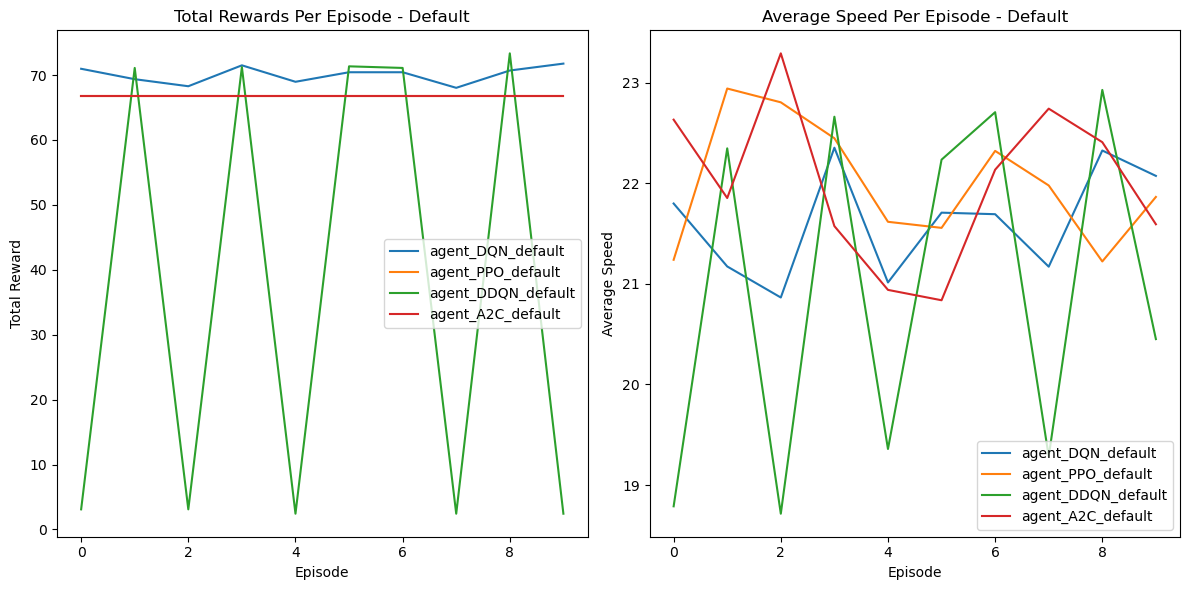

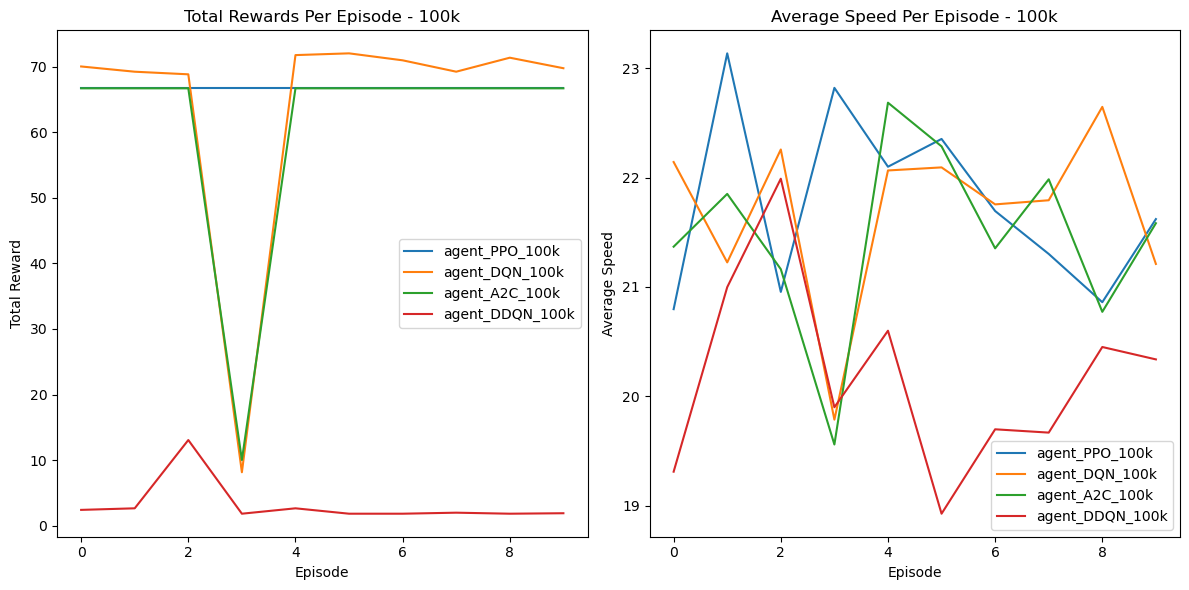

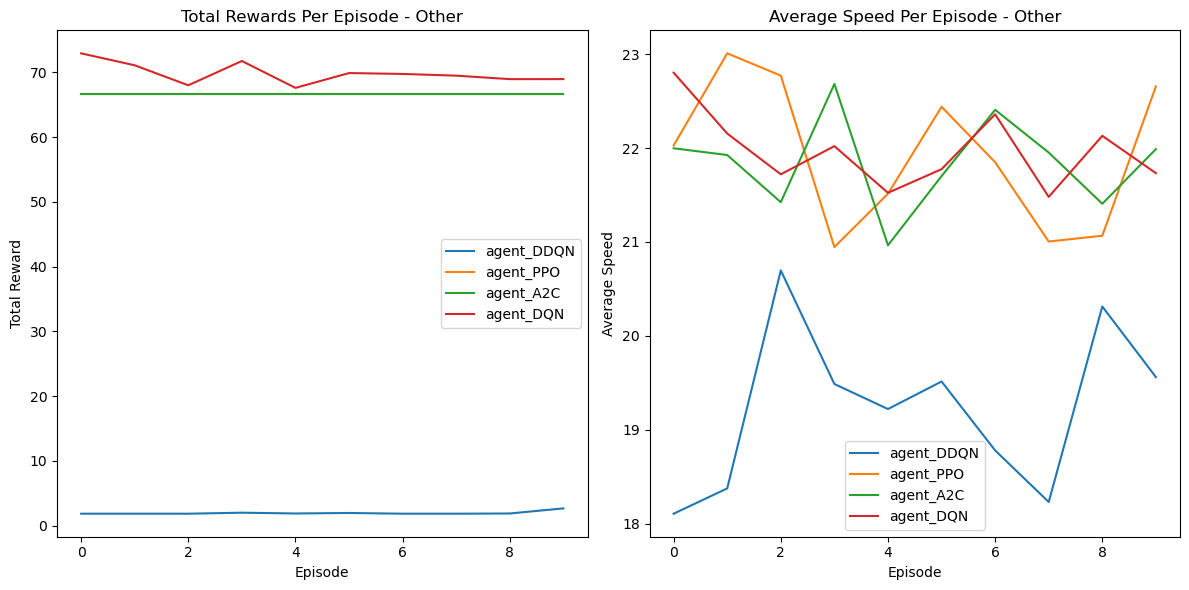

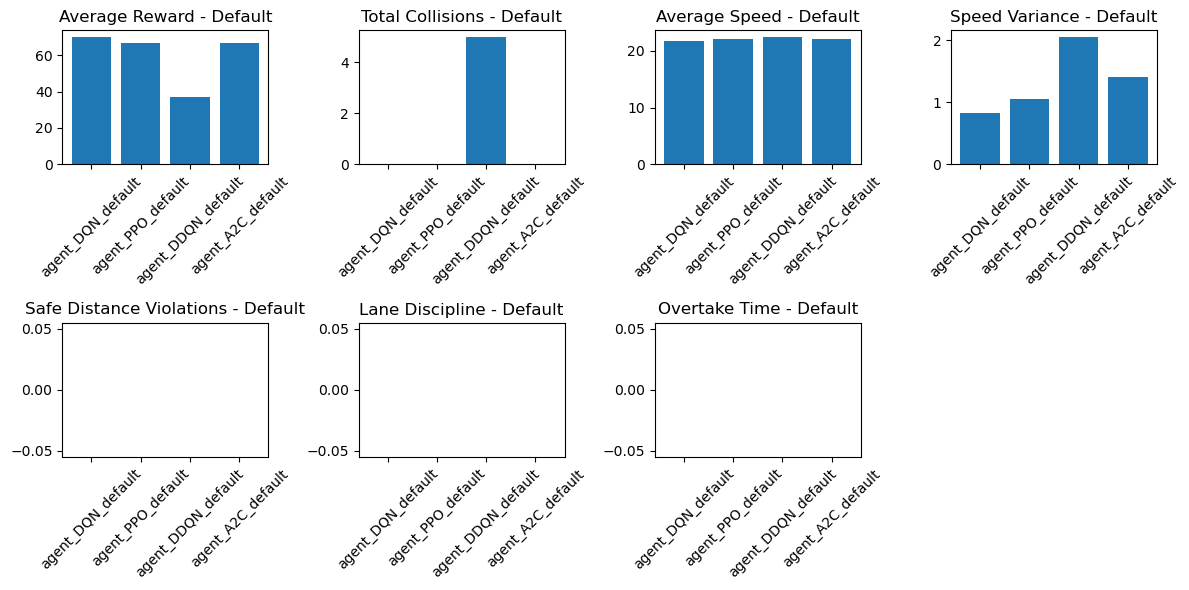

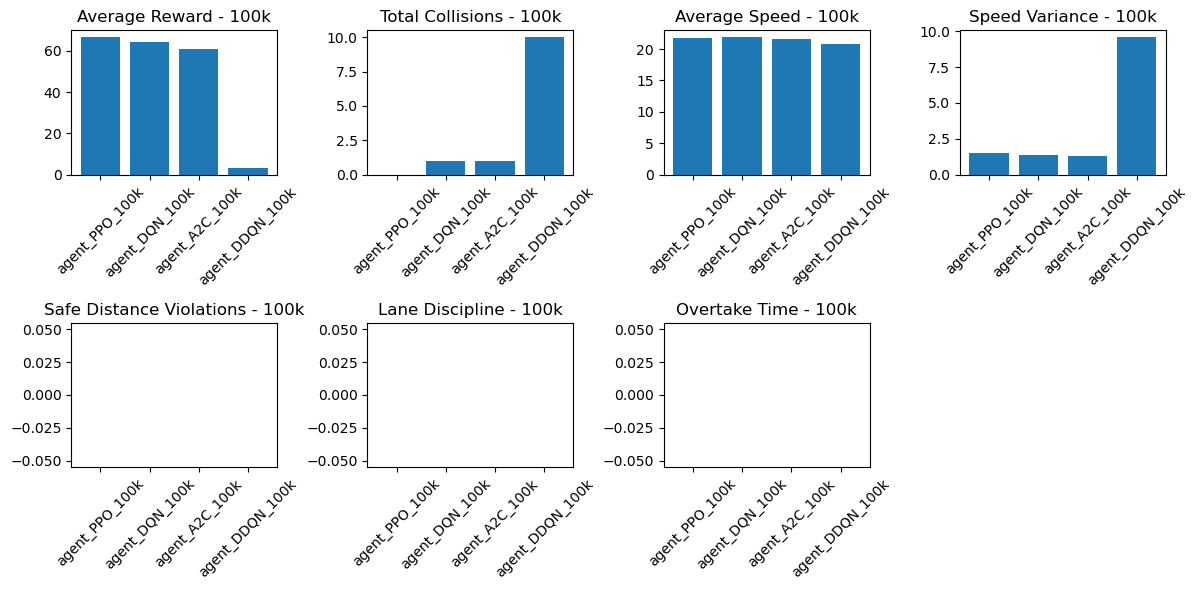

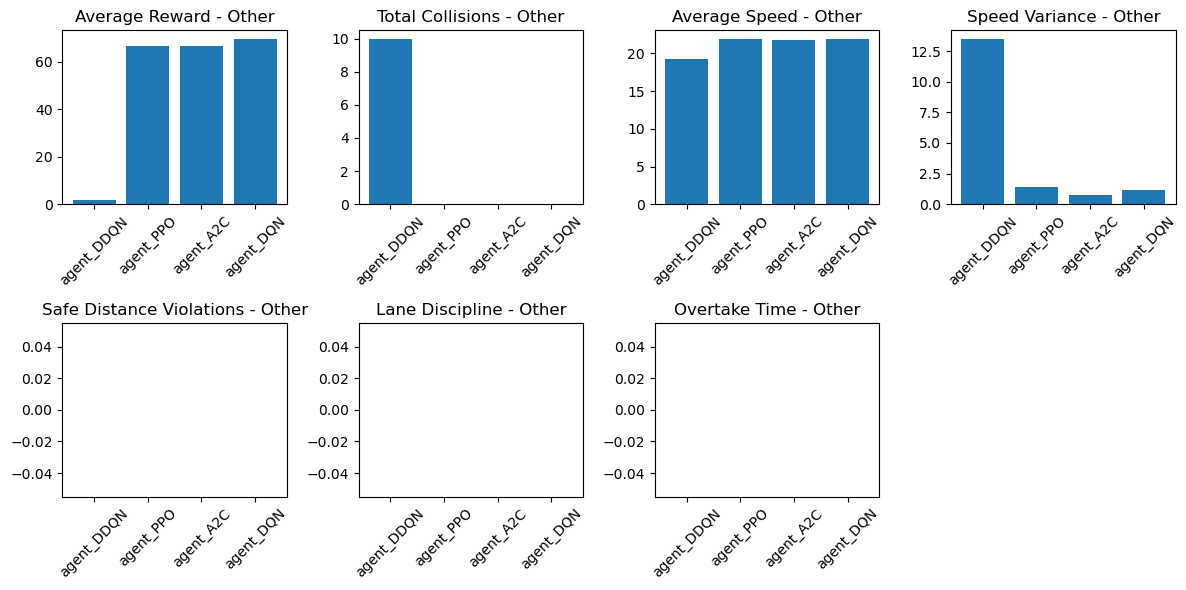

In [ ]:
import os
import json
import matplotlib.pyplot as plt


# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "car_following_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store episodic and overall metrics
            metrics_dict[agent_dir] = {
                "episodes": [result["episode"] for result in data["test_results"]],
                "total_rewards": [result["total_reward"] for result in data["test_results"]],
                "avg_speeds": [result["avg_speed"] for result in data["test_results"]],
                "speed_variances": [result["speed_variance"] for result in data["test_results"]],
                "kpis": data["kpis"]
            }
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Define a function to plot metrics
def plot_metrics(metrics, title_suffix):
    plt.figure(figsize=(12, 6))

    # Plot total rewards
    plt.subplot(1, 2, 1)
    for agent, data in metrics.items():
        plt.plot(data["episodes"], data["total_rewards"], label=agent)
    plt.title(f"Total Rewards Per Episode - {title_suffix}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    # Plot average speeds
    plt.subplot(1, 2, 2)
    for agent, data in metrics.items():
        plt.plot(data["episodes"], data["avg_speeds"], label=agent)
    plt.title(f"Average Speed Per Episode - {title_suffix}")
    plt.xlabel("Episode")
    plt.ylabel("Average Speed")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics for each category
plot_metrics(default_metrics, "Default")
plot_metrics(hundredk_metrics, "100k")
plot_metrics(other_metrics, "Other")

# Function to plot KPIs
def plot_kpis(metrics, title_suffix):
    if not metrics:
        print(f"No data available for {title_suffix} category.")
        return

    plt.figure(figsize=(12, 6))

    kpi_names = list(next(iter(metrics.values()))["kpis"].keys())
    kpi_values = {kpi: [] for kpi in kpi_names}

    for agent, data in metrics.items():
        for kpi in kpi_names:
            kpi_values[kpi].append(data["kpis"][kpi])

    # Plot each KPI as a bar chart
    for i, kpi in enumerate(kpi_names):
        plt.subplot(2, 4, i + 1)
        plt.bar(metrics.keys(), kpi_values[kpi])
        plt.title(f"{kpi.replace('_', ' ').title()} - {title_suffix}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Plot KPIs for each category
plot_kpis(default_metrics, "Default")
plot_kpis(hundredk_metrics, "100k")
plot_kpis(other_metrics, "Other")


### Just car following

In [53]:
import os
import json
import pandas as pd

# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "car_following_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store overall KPI metrics
            metrics_dict[agent_dir] = data["kpis"]
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Convert metrics dictionaries to DataFrames
def create_dataframe(metrics_dict, category_name):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df['Category'] = category_name
    return df

default_df = create_dataframe(default_metrics, 'Default')
hundredk_df = create_dataframe(hundredk_metrics, '100k')
other_df = create_dataframe(other_metrics, 'Other')

# Combine all DataFrames
combined_df = pd.concat([default_df, hundredk_df, other_df]).reset_index()
combined_df.rename(columns={'index': 'Agent'}, inplace=True)

# Extract base agent names for separation
combined_df['Base_Agent'] = combined_df['Agent'].str.replace('_default', '').str.replace('_100k', '')

# Function to display the table for each base agent
def display_agent_tables(base_agent_name):
    agent_df = combined_df[combined_df['Base_Agent'] == base_agent_name].drop(columns='Base_Agent')

    # Style the DataFrame for better visual presentation
    styled_df = agent_df.style.set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
    ]).set_properties(**{'text-align': 'center'}).set_caption(f"{base_agent_name} - Metrics Comparison")

    # Display the styled DataFrame
    display(styled_df)

# Loop through each unique base agent and display its table
unique_base_agents = combined_df['Base_Agent'].unique()
for base_agent in unique_base_agents:
    display_agent_tables(base_agent)


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
0,agent_DQN_default,70.037115,0,21.617856,0.833334,0.000000,0.000000,0.000000,Default
5,agent_DQN_100k,64.131783,1,21.879344,1.352561,0.000000,0.000000,0.000000,100k
11,agent_DQN,69.845869,0,21.970714,1.164009,0.000000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
1,agent_PPO_default,66.694148,0,21.999829,1.060080,0.000000,0.000000,0.000000,Default
4,agent_PPO_100k,66.694148,0,21.763721,1.509671,0.000000,0.000000,0.000000,100k
9,agent_PPO,66.694148,0,21.929144,1.419392,0.000000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
2,agent_DDQN_default,37.153459,5,22.436673,2.054051,0.000000,0.000000,0.000000,Default
7,agent_DDQN_100k,3.208476,10,20.783318,9.589250,0.000000,0.000000,0.000000,100k
8,agent_DDQN,1.955816,10,19.238597,13.518373,0.000000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
3,agent_A2C_default,66.694148,0,22.001079,1.403721,0.000000,0.000000,0.000000,Default
6,agent_A2C_100k,61.027481,1,21.634645,1.316475,0.000000,0.000000,0.000000,100k
10,agent_A2C,66.694148,0,21.845741,0.781440,0.000000,0.000000,0.000000,Other


### Just overtaking

In [54]:
import os
import json
import pandas as pd

# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "highway_cruising_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store overall KPI metrics
            metrics_dict[agent_dir] = data["kpis"]
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Convert metrics dictionaries to DataFrames
def create_dataframe(metrics_dict, category_name):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df['Category'] = category_name
    return df

default_df = create_dataframe(default_metrics, 'Default')
hundredk_df = create_dataframe(hundredk_metrics, '100k')
other_df = create_dataframe(other_metrics, 'Other')

# Combine all DataFrames
combined_df = pd.concat([default_df, hundredk_df, other_df]).reset_index()
combined_df.rename(columns={'index': 'Agent'}, inplace=True)

# Extract base agent names for separation
combined_df['Base_Agent'] = combined_df['Agent'].str.replace('_default', '').str.replace('_100k', '')

# Function to display the table for each base agent
def display_agent_tables(base_agent_name):
    agent_df = combined_df[combined_df['Base_Agent'] == base_agent_name].drop(columns='Base_Agent')

    # Style the DataFrame for better visual presentation
    styled_df = agent_df.style.set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
    ]).set_properties(**{'text-align': 'center'}).set_caption(f"{base_agent_name} - Metrics Comparison")

    # Display the styled DataFrame
    display(styled_df)

# Loop through each unique base agent and display its table
unique_base_agents = combined_df['Base_Agent'].unique()
for base_agent in unique_base_agents:
    display_agent_tables(base_agent)


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
0,agent_DQN_default,114.902468,7,20.674621,0.921499,474.600000,0.000000,0.000000,Default
5,agent_DQN_100k,160.764786,5,20.819580,1.031588,552.000000,0.000000,0.000000,100k
11,agent_DQN,71.947316,8,20.690756,1.321094,184.900000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
1,agent_PPO_default,207.027481,0,20.840290,1.044388,54.000000,0.000000,0.000000,Default
4,agent_PPO_100k,213.027481,0,20.724912,0.806904,9.300000,0.000000,0.000000,100k
9,agent_PPO,190.260815,1,20.735237,0.902565,44.400000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
2,agent_DDQN_default,86.283054,8,20.727635,1.132877,411.100000,0.000000,0.000000,Default
7,agent_DDQN_100k,83.879176,10,20.542603,0.961774,423.300000,0.000000,0.000000,100k
8,agent_DDQN,42.818231,10,20.497253,1.383501,226.300000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
3,agent_A2C_default,196.494148,1,20.829785,0.936036,45.600000,0.000000,0.000000,Default
6,agent_A2C_100k,185.233747,2,20.846101,1.053802,128.800000,0.000000,0.000000,100k
10,agent_A2C,149.254148,5,20.774391,1.057399,42.900000,0.000000,0.000000,Other


### Just highway cruising 

In [55]:
import os
import json
import pandas as pd

# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "overtaking_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store overall KPI metrics
            metrics_dict[agent_dir] = data["kpis"]
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Convert metrics dictionaries to DataFrames
def create_dataframe(metrics_dict, category_name):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df['Category'] = category_name
    return df

default_df = create_dataframe(default_metrics, 'Default')
hundredk_df = create_dataframe(hundredk_metrics, '100k')
other_df = create_dataframe(other_metrics, 'Other')

# Combine all DataFrames
combined_df = pd.concat([default_df, hundredk_df, other_df]).reset_index()
combined_df.rename(columns={'index': 'Agent'}, inplace=True)

# Extract base agent names for separation
combined_df['Base_Agent'] = combined_df['Agent'].str.replace('_default', '').str.replace('_100k', '')

# Function to display the table for each base agent
def display_agent_tables(base_agent_name):
    agent_df = combined_df[combined_df['Base_Agent'] == base_agent_name].drop(columns='Base_Agent')

    # Style the DataFrame for better visual presentation
    styled_df = agent_df.style.set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
    ]).set_properties(**{'text-align': 'center'}).set_caption(f"{base_agent_name} - Metrics Comparison")

    # Display the styled DataFrame
    display(styled_df)

# Loop through each unique base agent and display its table
unique_base_agents = combined_df['Base_Agent'].unique()
for base_agent in unique_base_agents:
    display_agent_tables(base_agent)


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
0,agent_DQN_default,130.193913,3,21.764278,0.860496,133.900000,0.000000,0.000000,Default
5,agent_DQN_100k,151.799844,3,21.800138,0.875825,53.500000,0.000000,0.000000,100k
11,agent_DQN,36.735065,10,21.756901,1.063334,3.700000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
1,agent_PPO_default,142.694148,0,21.975653,0.825351,0.000000,0.000000,0.000000,Default
4,agent_PPO_100k,143.382656,0,21.608634,0.648562,0.000000,0.000000,0.000000,100k
9,agent_PPO,141.360815,0,21.706125,0.755579,0.000000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
2,agent_DDQN_default,115.494663,5,21.546191,0.765788,82.600000,0.000000,0.000000,Default
7,agent_DDQN_100k,97.043341,6,21.732993,0.985531,111.200000,0.000000,0.000000,100k
8,agent_DDQN,49.191791,9,21.655998,0.972337,80.500000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
3,agent_A2C_default,142.694148,0,21.713506,0.560369,0.000000,0.000000,0.000000,Default
6,agent_A2C_100k,23.916878,10,21.672077,1.182628,0.800000,0.000000,0.000000,100k
10,agent_A2C,134.694148,0,21.663210,0.741599,0.000000,0.000000,0.000000,Other


### Just roundabout

In [56]:
import os
import json
import pandas as pd

# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "roundabout_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store overall KPI metrics
            metrics_dict[agent_dir] = data["kpis"]
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Convert metrics dictionaries to DataFrames
def create_dataframe(metrics_dict, category_name):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df['Category'] = category_name
    return df

default_df = create_dataframe(default_metrics, 'Default')
hundredk_df = create_dataframe(hundredk_metrics, '100k')
other_df = create_dataframe(other_metrics, 'Other')

# Combine all DataFrames
combined_df = pd.concat([default_df, hundredk_df, other_df]).reset_index()
combined_df.rename(columns={'index': 'Agent'}, inplace=True)

# Extract base agent names for separation
combined_df['Base_Agent'] = combined_df['Agent'].str.replace('_default', '').str.replace('_100k', '')

# Function to display the table for each base agent
def display_agent_tables(base_agent_name):
    agent_df = combined_df[combined_df['Base_Agent'] == base_agent_name].drop(columns='Base_Agent')

    # Style the DataFrame for better visual presentation
    styled_df = agent_df.style.set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
    ]).set_properties(**{'text-align': 'center'}).set_caption(f"{base_agent_name} - Metrics Comparison")

    # Display the styled DataFrame
    display(styled_df)

# Loop through each unique base agent and display its table
unique_base_agents = combined_df['Base_Agent'].unique()
for base_agent in unique_base_agents:
    display_agent_tables(base_agent)


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
0,agent_DQN_default,6.797059,4,13.962079,16.539628,7.100000,0.000000,0.000000,Default
5,agent_DQN_100k,6.626961,4,14.568349,6.639964,5.200000,0.000000,0.000000,100k
11,agent_DQN,6.780882,4,14.324369,7.372941,7.200000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
1,agent_PPO_default,4.803922,7,15.335508,15.389721,6.400000,0.000000,0.000000,Default
4,agent_PPO_100k,6.083333,3,15.795694,5.152022,8.100000,0.000000,0.000000,100k
9,agent_PPO,8.095588,2,14.426288,10.620920,6.900000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
2,agent_DDQN_default,8.935294,2,14.734225,12.595649,9.800000,0.000000,0.000000,Default
7,agent_DDQN_100k,8.333333,3,15.544491,5.736452,11.900000,0.000000,0.000000,100k
8,agent_DDQN,8.656373,3,14.426411,17.620496,7.700000,0.000000,0.000000,Other


,Agent,average_reward,total_collisions,average_speed,speed_variance,safe_distance_violations,lane_discipline,overtake_time,Category
3,agent_A2C_default,6.862745,5,14.561936,15.807226,7.500000,0.000000,0.000000,Default
6,agent_A2C_100k,9.069608,1,14.585974,7.657717,8.100000,0.000000,0.000000,100k
10,agent_A2C,7.156863,4,15.293962,7.492098,8.100000,0.000000,0.000000,Other


### Traffic flow impact

Agent: agent_DQN_default (Default)
  - Average Speed: 21.62
  - Speed Variance: 0.57
  - Total Reward: 70.04
  - Traffic Flow Impact: 13.76


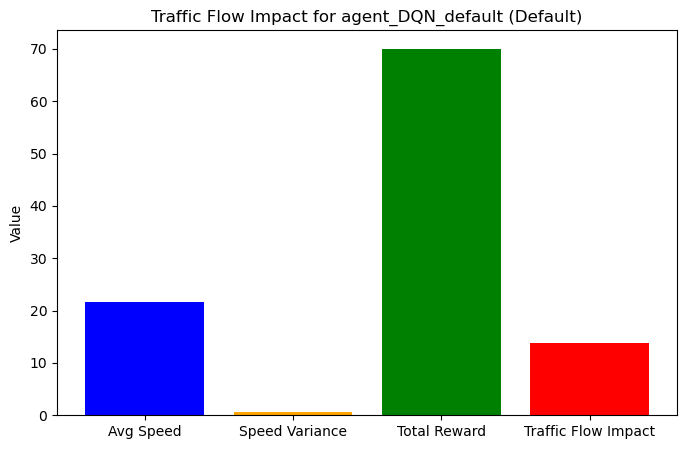

Agent: agent_PPO_default (Default)
  - Average Speed: 22.00
  - Speed Variance: 0.72
  - Total Reward: 66.69
  - Traffic Flow Impact: 12.78


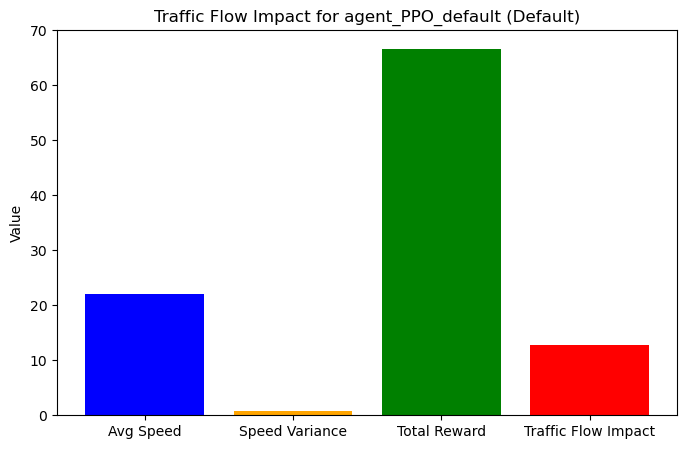

Agent: agent_DDQN_default (Default)
  - Average Speed: 20.95
  - Speed Variance: 5.99
  - Total Reward: 37.15
  - Traffic Flow Impact: 3.00


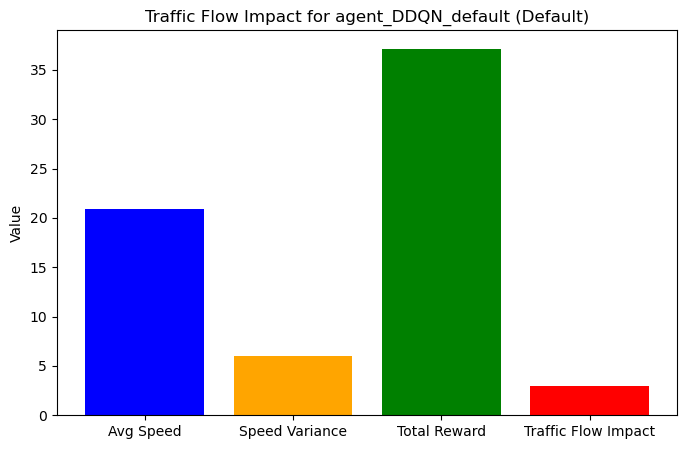

Agent: agent_A2C_default (Default)
  - Average Speed: 22.00
  - Speed Variance: 0.84
  - Total Reward: 66.69
  - Traffic Flow Impact: 11.96


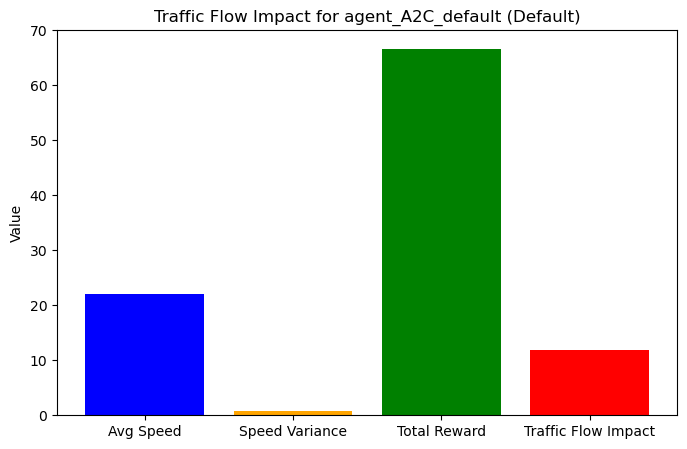

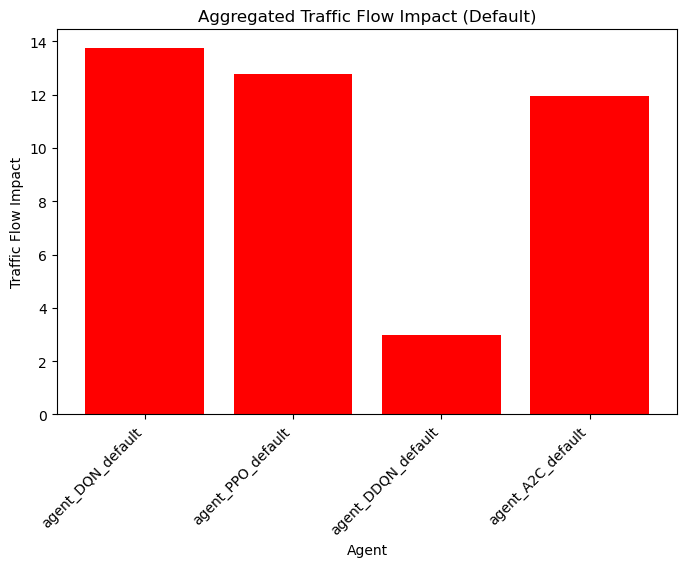

Agent: agent_PPO_100k (100k)
  - Average Speed: 21.76
  - Speed Variance: 0.90
  - Total Reward: 66.69
  - Traffic Flow Impact: 11.46


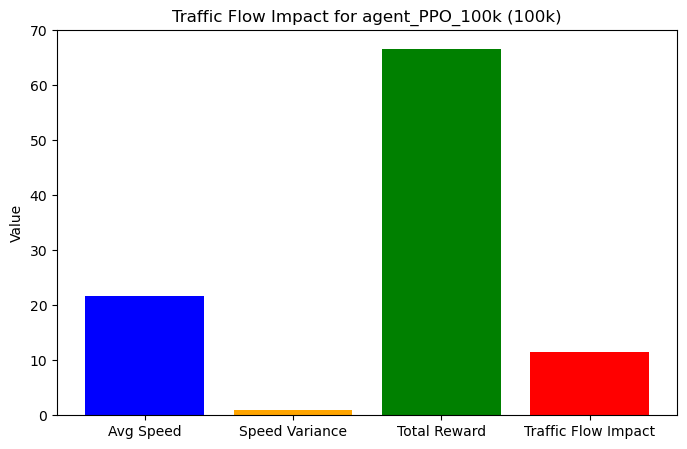

Agent: agent_DQN_100k (100k)
  - Average Speed: 21.70
  - Speed Variance: 1.66
  - Total Reward: 64.13
  - Traffic Flow Impact: 8.15


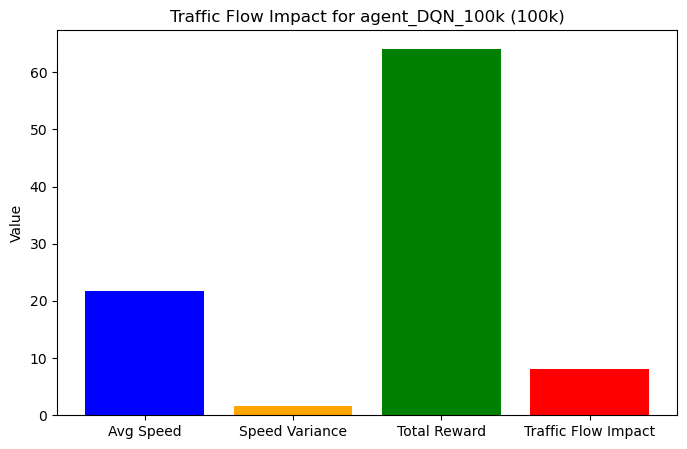

Agent: agent_A2C_100k (100k)
  - Average Speed: 21.46
  - Speed Variance: 1.24
  - Total Reward: 61.03
  - Traffic Flow Impact: 9.57


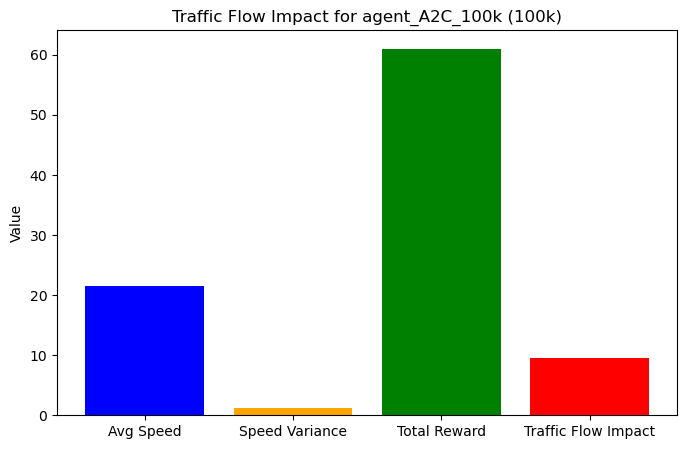

Agent: agent_DDQN_100k (100k)
  - Average Speed: 20.19
  - Speed Variance: 10.09
  - Total Reward: 3.21
  - Traffic Flow Impact: 1.82


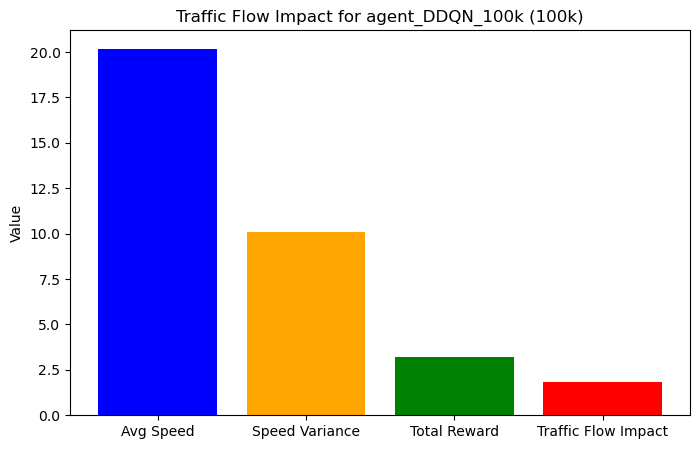

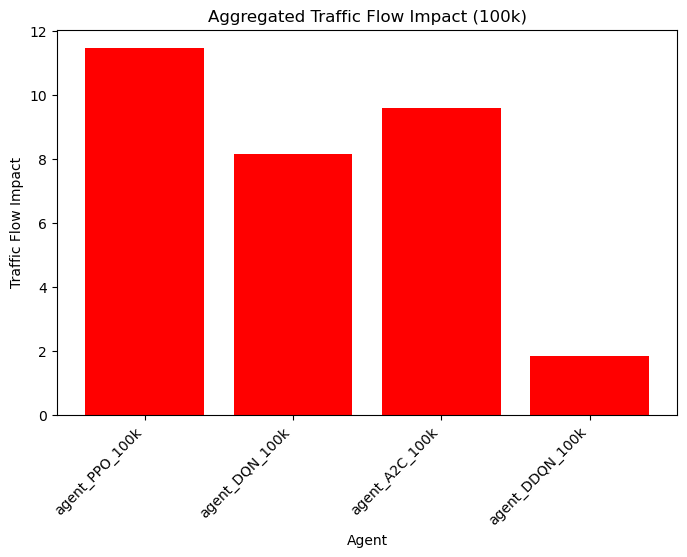

Agent: agent_DDQN (Other)
  - Average Speed: 19.23
  - Speed Variance: 12.47
  - Total Reward: 1.96
  - Traffic Flow Impact: 1.43


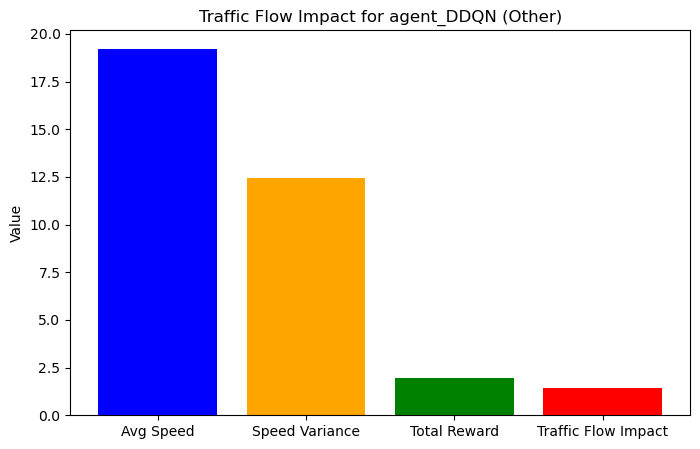

Agent: agent_PPO (Other)
  - Average Speed: 21.93
  - Speed Variance: 0.88
  - Total Reward: 66.69
  - Traffic Flow Impact: 11.68


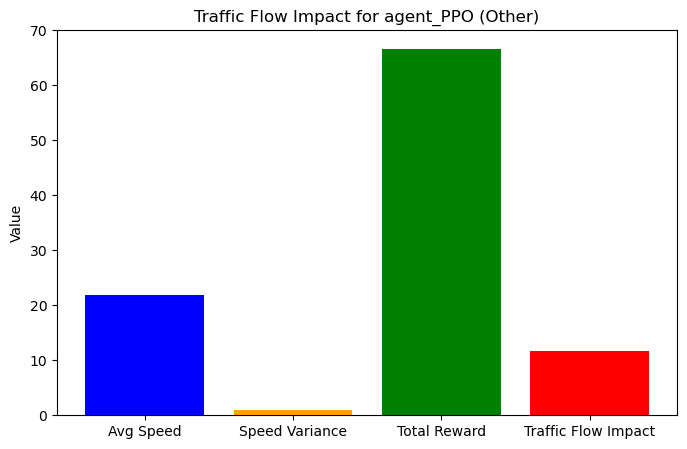

Agent: agent_A2C (Other)
  - Average Speed: 21.85
  - Speed Variance: 0.56
  - Total Reward: 66.69
  - Traffic Flow Impact: 14.03


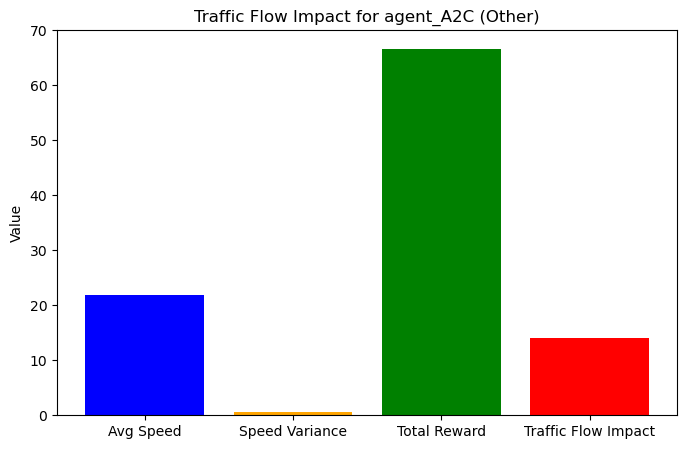

Agent: agent_DQN (Other)
  - Average Speed: 21.97
  - Speed Variance: 1.01
  - Total Reward: 69.85
  - Traffic Flow Impact: 10.91


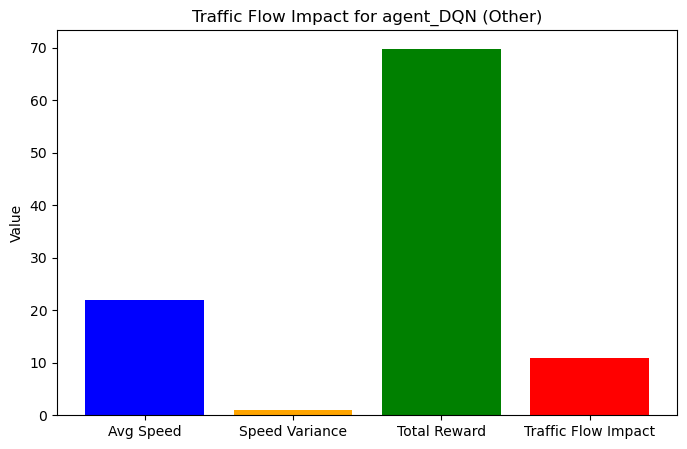

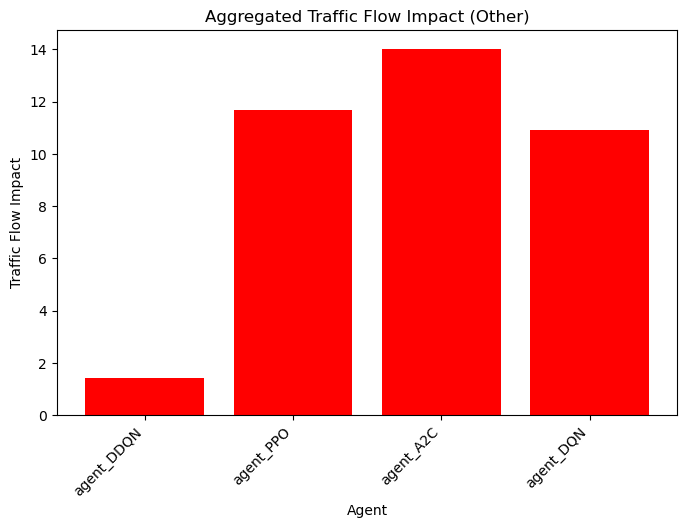

In [58]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the results directory
results_dir = "./outputs/results"  # Update this to your actual relative or absolute path

# Check if the directory exists
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"The directory '{results_dir}' does not exist. Please check the path.")

# Initialize dictionaries to store metrics for different categories
default_metrics = {}
hundredk_metrics = {}
other_metrics = {}

# Function to process and store metrics for a given agent directory
def process_agent_dir(agent_dir, agent_path, metrics_dict):
    target_file_name = "car_following_post_training_test_data.json"
    file_path = os.path.join(agent_path, target_file_name)
    
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r") as file:
                data = json.load(file)

            # Validate the presence of required keys
            if "test_results" not in data or "kpis" not in data:
                print(f"Skipping {file_path}: Missing 'test_results' or 'kpis' keys.")
                return

            # Store overall KPI metrics
            metrics_dict[agent_dir] = {
                "episodes": [result["episode"] for result in data["test_results"]],
                "total_rewards": [result["total_reward"] for result in data["test_results"]],
                "avg_speeds": [result["avg_speed"] for result in data["test_results"]],
                "speed_variances": [result["speed_variance"] for result in data["test_results"]],
                "kpis": data["kpis"]
            }
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Iterate over each agent's directory and categorize them
for agent_dir in os.listdir(results_dir):
    agent_path = os.path.join(results_dir, agent_dir)
    if os.path.isdir(agent_path):
        if agent_dir.endswith("default"):
            process_agent_dir(agent_dir, agent_path, default_metrics)
        elif agent_dir.endswith("100k"):
            process_agent_dir(agent_dir, agent_path, hundredk_metrics)
        else:
            process_agent_dir(agent_dir, agent_path, other_metrics)

# Function to calculate average metrics for a given agent
def calculate_average_metrics(metrics):
    avg_speed = sum(metrics["avg_speeds"]) / len(metrics["avg_speeds"])
    speed_variance = sum(metrics["speed_variances"]) / len(metrics["speed_variances"])
    total_reward = sum(metrics["total_rewards"]) / len(metrics["total_rewards"])
    return avg_speed, speed_variance, total_reward

# Function to calculate the traffic flow impact (new metric)
def calculate_traffic_flow_impact(metrics):
    avg_speed, speed_variance, total_reward = calculate_average_metrics(metrics)
    
    # Define a basic traffic flow impact formula
    traffic_flow_impact = avg_speed / (speed_variance + 1)  # Dividing by variance to penalize high speed fluctuations
    return traffic_flow_impact, avg_speed, speed_variance, total_reward

# Function to plot the traffic flow impact for each agent
def plot_traffic_flow_impact(agent_metrics, category):
    traffic_impact_values = []
    avg_speeds = []
    speed_variances = []
    total_rewards = []

    for agent, metrics in agent_metrics.items():
        traffic_flow_impact, avg_speed, speed_variance, total_reward = calculate_traffic_flow_impact(metrics)
        
        print(f"Agent: {agent} ({category})")
        print(f"  - Average Speed: {avg_speed:.2f}")
        print(f"  - Speed Variance: {speed_variance:.2f}")
        print(f"  - Total Reward: {total_reward:.2f}")
        print(f"  - Traffic Flow Impact: {traffic_flow_impact:.2f}")
        
        # Collect values for plotting
        traffic_impact_values.append(traffic_flow_impact)
        avg_speeds.append(avg_speed)
        speed_variances.append(speed_variance)
        total_rewards.append(total_reward)
        
        # Plotting traffic flow impact (example visualization)
        plt.figure(figsize=(8, 5))
        plt.bar(['Avg Speed', 'Speed Variance', 'Total Reward', 'Traffic Flow Impact'],
                [avg_speed, speed_variance, total_reward, traffic_flow_impact],
                color=['blue', 'orange', 'green', 'red'])
        plt.title(f"Traffic Flow Impact for {agent} ({category})")
        plt.ylabel('Value')
        plt.show()

    # Plot aggregated traffic flow impact for category
    plt.figure(figsize=(8, 5))
    plt.bar(list(agent_metrics.keys()), traffic_impact_values, color='red')
    plt.title(f"Aggregated Traffic Flow Impact ({category})")
    plt.ylabel('Traffic Flow Impact')
    plt.xlabel('Agent')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for Default category agents
plot_traffic_flow_impact(default_metrics, 'Default')

# Plot for 100k category agents
plot_traffic_flow_impact(hundredk_metrics, '100k')

# Plot for Other category agents
plot_traffic_flow_impact(other_metrics, 'Other')


## Conclusion